In [1]:
import tsl
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy
from torch_geometric.nn import MessagePassing
from einops import rearrange
plt.style.use('ggplot')

# Air quality forecasting with spatiotemporal graph neural networks (STGNN)

We use Torch Spatiotemporal (tsl), a Python library for neural spatiotemporal data processing that focuses on GNNs. 

This notebook took inspiration from the official tsl tutorial "A Gentle Introduction to tsl".

In [2]:
from tsl.datasets import AirQuality
dataset = AirQuality(root='./data', small=True, impute_nans=True, )

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.



#### Spatiotemporal graphs
<p align="center">
  <img src="./imgs/temporal_graph.png" alt="temp_graph" width="600"/>
</p>

<p align="center">
  <img src="./imgs/temporal_graph_timeseries.png" alt="timeseries" width="600"/>
</p>

In [3]:
# The graph is not given a priori, however we can access some similarity metric between the nodes
print(f"We have the following similarity options: {dataset.similarity_options}")
sim = dataset.get_similarity("distance")

We have the following similarity options: {'distance'}


In [4]:
dataset.covariates.keys()

dict_keys(['dist', 'eval_mask'])

In [5]:
connectivity = dataset.get_connectivity(method='distance',
                                        threshold=0.1,
                                        include_self=False,
                                        layout="edge_index")

In [6]:
edge_index, edge_weight = connectivity 
edge_index, edge_weight = torch.tensor(edge_index), torch.tensor(edge_weight)

In [7]:
rad = .2
conn_style = f'arc3,rad={rad}'

def offset(d, pos, dist = rad/2, loop_shift = .2):
    for (u,v),obj in d.items():
        if u!=v:
            par = dist*(pos[v] - pos[u])
            dx,dy = par[1],-par[0]
            x,y = obj.get_position()
            obj.set_position((x+dx,y+dy))
        else:
            x,y = obj.get_position()
            obj.set_position((x,y+loop_shift))

def draw_graph(edge_index, edge_values=None):
        edge_list = edge_index.numpy().T.tolist()

        G = nx.MultiDiGraph()
        G.add_edges_from(edge_list)


        pos = nx.kamada_kawai_layout(G)


        nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
        nx.draw_networkx_labels(G, pos=pos, font_color='black', font_size=10)
        nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), edge_color='black',
                        connectionstyle=conn_style)
        
        if edge_values is not None:
        # Draw edges with colors based on the starting node
                edge_value_list = edge_values.numpy().tolist() 
                edge_labels = {tuple(edge): f'{value:.2f}' for edge, value in zip(edge_list, edge_value_list)}
                d = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=5)
                offset(d,pos)
        plt.gca().set_aspect('equal')

        plt.show()

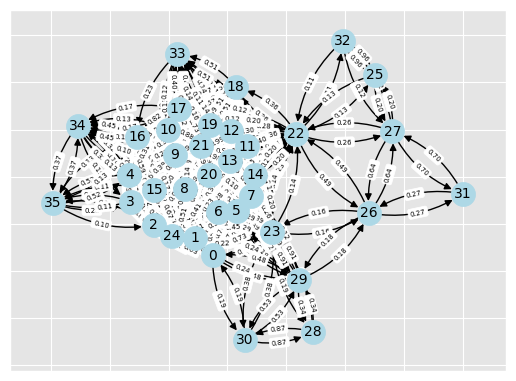

In [8]:
draw_graph(edge_index=edge_index, edge_values=edge_weight)

In [9]:
from tsl.data import SpatioTemporalDataset

# Parameters taken from https://arxiv.org/abs/2302.04071
window = 24
horizon = 3
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      connectivity=connectivity,
                                      mask=dataset.mask,
                                      horizon=horizon,
                                      window=window,
                                      stride=1)
print(torch_dataset)
# Each sample generated with a sliding window as follows:
# |---------------x------------------------------------ ...  ------| <- time series
# |----input----|-delay-|---target---|              <- sample 1
# |-stride-|----input----|-delay-|---target---|     <- sample 2

# The sliding window has 24 time steps for the lockback window and an horizon of 3 time steps
# to generate the input and target sequence respectively.
# Between input and target there can be a delay (default=0) and between consecutive samples there is 
# a stride (default=1)

SpatioTemporalDataset(n_samples=8733, n_nodes=36, n_channels=1)


In [10]:
sample = torch_dataset[0]
sample

Data(
  input=(x=[t=24, n=36, f=1], edge_index=[2, e=654], edge_weight=[e=654]),
  target=(y=[t=3, n=36, f=1]),
  has_mask=True
)

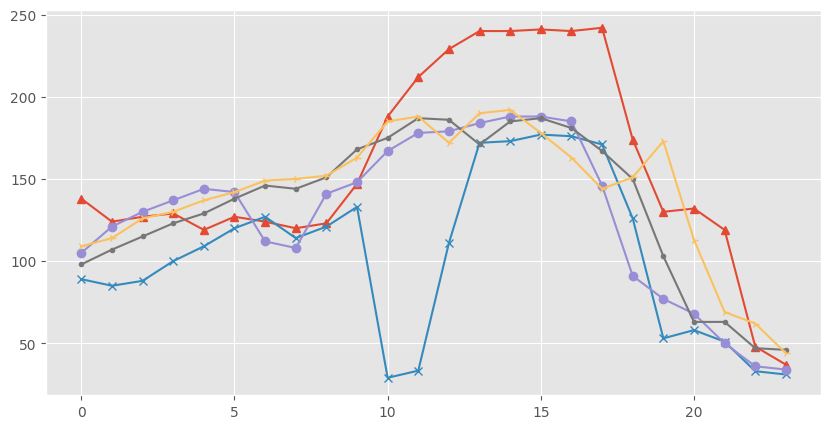

In [11]:
# Look at the data; there seem to be correlation.
# This is a good sign that GNNs can be helpful to forecast this process.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample.x[:,0], marker='^')
ax.plot(sample.x[:,1], marker='x')
ax.plot(sample.x[:,2], marker='o')
ax.plot(sample.x[:,3], marker='.')
ax.plot(sample.x[:,-1], marker='4')

In [12]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler


scalers = {'target': StandardScaler(axis=(0, 1))}

# The dataset is split into train/val/test along the temporal axis: 
#   |-------- whole dataset ---------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)


In [13]:
dm.setup() # lazy

### Time-then-Space Models

These are models where there time and space are handled saparately. 

First, each time series is embedded into a vector:

$$h_t^i = \text{TemporalModel}(x_{\leq t}^i)$$

Then, information is propagated through space with a series of message-passing layers:

$$
H_t^{(l+1)} = \text{GNN}^{(l)}(H_t^l, A_t)
$$

*Sources: "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023)*

In [15]:
import torch.nn as nn

from tsl.nn.models import RNNModel, GatedGraphNetworkModel, GraphWaveNetModel, VARModel
from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation

# This model is taken from the "A Gentle Introduction to tsl" tutorial. 
# Below we define other models.
class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_layers: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size * horizon)

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.time_model = RNN(input_size=hidden_size,
                            hidden_size=hidden_size,
                            n_layers=rnn_layers,
                            cell='gru',
                            return_only_last_state=True)

        self.space_model = DiffConv(in_channels=hidden_size,
                                    out_channels=hidden_size,
                                    k=gnn_layers)

        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        x = self.encoder(x) 
        x = x + self.node_embeddings()  

        h = self.time_model(x) 
        z = self.space_model(h, edge_index, edge_weight)
        return self.rearrange(self.decoder(z))


### Space-then-Time Models

These models first propagate information in the spatial dimension for each time step, to obtain time series enhanced by the spatial relationships:

$$
H_t^{(l+1)} = \text{GNN}^{(l)}(H_t^l, A_t) \quad \forall t \in \{t-W, \dots, t\}
$$

Then, the resulting timeseries are processed by a sequence model: 

$$
h_t^i = \text{TemporalModel}(h_{t-W:t}^i)
$$

*Sources: "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023)*

In [16]:
class SpaceThenTimeModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_layers: int = 2):
        super(SpaceThenTimeModel, self).__init__()

        self.time_model = RNN(input_size=hidden_size,
                            hidden_size=hidden_size,
                            n_layers=rnn_layers,
                            cell='gru',
                            return_only_last_state=True)
        
        self.space_model = DiffConv(in_channels=hidden_size,
                                    out_channels=hidden_size,
                                    k=gnn_layers)
        
        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        batch_size, win_size, num_nodes, num_feats = x.size()

        x = self.encoder(x)
        x = x + self.node_embeddings()

        x_enhanced = []
        for t in range(0, win_size):
            x_enhanced.append(self.space_model(x[:,t], edge_index, edge_weight))
        x_enhanced = torch.stack(x_enhanced, dim=1)

        h = self.time_model(x_enhanced) 
        return self.rearrange(self.decoder(h))

In [17]:
dummy_data = torch.randn(32,14,8,1)
ei = torch.tensor([[0, 1],[0,2],[0,3],[1,0],[1,2],[2,1],[2,0],[3,0]], dtype=torch.long).T
m = SpaceThenTimeModel(input_size=1, n_nodes=8, horizon=3, hidden_size=32, rnn_layers=2, gnn_layers=2)
m(dummy_data, edge_index=ei, edge_weight=None).shape

torch.Size([32, 3, 8, 1])

### Time-and-Space Models

The third category of STGNN does not have a clear separation between the processing of the temporal and spatial dimension.  

Examples include: 
- Temporal operators to compute messages, such as temporal convolutions (TCN):
$$ h_{t-W:t}^{i,(l+1)} = \text{TCN}_{\text{up}} \left( h_{t-W:t}^{i,(l)}, \text{Aggr} 
    \{ \text{TCN}_{\text{msg}} \left(h_{t-W:t}^{i,(l)},h_{t-W:t}^{j,(l)},e_{t-W:t}^{ij}\right); j\in \mathcal{N}_{t,i}\} \right)$$
- Interleave spatial convolution with temporal convolutions: 
$$
  \begin{aligned}
    z_{t-W:t}^{i,(l)} & = \text{TCN}^{(l)} \left(h_{t-W:t}^{i,(l-1)}\right) & \quad \forall i \\
    H_t^{(l)} & = \text{GNN}^{(l)} \left( Z_t^{(l)}, A_{t} \right) & \quad \forall t
  \end{aligned}
$$

- Use message-passing in models used for sequential data processing. For example, recurrent networks can use graph convolutions instead of vector-matrix multiplications. The vanilla RNN $h_t=\sigma (W_xx_t + W_hh_{t-1})$ would become:

$$
h_t^i = \sigma\left(\text{GNN}(x_t^i, A_t) + \text{GNN}(h_{t-1}^i, A_{t-1})\right)
$$

Below we find an example of  graph convolution recurrent networks.


*Sources: "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023), "Structured Sequence Modeling with Graph Convolutional Recurrent Networks" (Seo et. al, 2016)*

In [18]:
# It may look complicated, but in the end it is a classic RNN, where instead of linear layers, GNN layers are used 
# to iterate over time. 
class GatedRecurrentGraphNetCell(MessagePassing):
    def __init__(self,
                 input_size: int,
                 state_size: int,
                 output_size: int,
                 skip_connection: bool = False):
        super(GatedRecurrentGraphNetCell, self).__init__(aggr="add")

        self.input_size = input_size
        self.state_size = state_size
        self.output_size = output_size
        self.skip_connection = skip_connection

        self.input_encoder = nn.Linear(input_size, state_size)
        self.state_encoder = nn.Linear(state_size, state_size)

        # Message network
        self.msg = nn.Sequential(
            nn.Linear(2*state_size, output_size),
            nn.ReLU(),
            nn.Linear(output_size, output_size),
            nn.ReLU()
        )
        # Gating network: Message -> [0,1]
        self.gate = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

        self.up = torch.nn.Sequential(
            nn.Linear(output_size+state_size, output_size),
            nn.ReLU(),
            nn.Linear(output_size, output_size),
            nn.ReLU() 
        )

        if skip_connection:
            if input_size != output_size:
                self.skip_conn = nn.Linear(input_size, output_size)
            else:
                self.skip_connection = nn.Identity()

    def forward(self, x, edge_index, h):

        # Handle the recurrence
        x_ = self.input_encoder(x) # d_in -> d_state
        h_ = self.state_encoder(h) # d_state -> d_state
        in_ = x_ + h_ 

        out = self.propagate(edge_index=edge_index, x=in_) 

        out = self.up(torch.cat([out, h], dim=-1)) 
        
        if self.skip_connection:
            out += self.skip_conn(x) 

        return out

    def message(self, x_i, x_j, edge_index):
        msg = self.msg(torch.cat([x_i,x_j], dim=-1)) 

        return self.gate(msg) * msg
    

class GatedRecurrentGraphNetModel(nn.Module):
    def __init__(self,
                 input_size,
                 state_size,
                 hidden_size,
                 horizon,
                 n_nodes,
                 n_layers=1,
                 skip_connection=True):
        super().__init__()


        self.input_size = input_size
        self.state_size = state_size
        self.hidden_size = hidden_size 
        self.n_layers = n_layers
        self.skip_connection = skip_connection
        self.horizon = horizon
        self.node_embeddings = NodeEmbedding(n_nodes, state_size)

        if state_size != hidden_size * n_layers:
            self.state_encoder = nn.Linear(state_size, hidden_size * n_layers)
            self.readout = nn.Linear(hidden_size * n_layers, state_size)
        else:
            self.state_encoder = nn.Identity()
            self.readout = nn.Identity()

        self.input_encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(state_size, input_size)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

        self.gated_graph_conv_layers = nn.ModuleList(
            [
                GatedRecurrentGraphNetCell(input_size=hidden_size,
                                           state_size=hidden_size,
                                           output_size=hidden_size,
                                           skip_connection=False) 
                                           for _ in range(n_layers)
            ])
            
    def iterate_layers(self, x, h, **kwargs):
        output = []

        for l, layer in enumerate(self.gated_graph_conv_layers):
            x = x + layer(x=x, h=h[l], **kwargs)
            output.append(x)

        return torch.cat(output, dim=-1)
        
    def forward(self, x, edge_index=None):

        batch_size, win_size, num_nodes, num_feats = x.size()
        if edge_index is None:
            # Generate a full graph for dynamic graph learning

            nodes = torch.arange(num_nodes, device=x.device)
            edge_index = torch.cartesian_prod(nodes, nodes).T

        state = torch.zeros(batch_size, num_nodes, self.state_size, device=x.device)

        # iterate in time
        for t in range(0, win_size):
            
            # Encode input and state
            h_ = self.state_encoder(state + self.node_embeddings())
            x_ = self.input_encoder(x[:,t])

            h_ = rearrange(h_, "b n ... (h l) -> l b n ... h", l=self.n_layers)
            # Iterate in depth 
            h_new = self.iterate_layers(x=x_, h=h_, edge_index=edge_index)

            h_ = rearrange(h_, 'l b n ... h -> b n ... (h l)', l=self.n_layers)

            if self.skip_connection: 
                h_new = h_new + h_
                
            state =  self.readout(h_new) # [b, n, s]

        # forecast the horizon
        outputs = []
        for t in range(0, self.horizon):
            out_ = self.decoder(state)
            outputs.append(out_)

            h_ = self.state_encoder(state + self.node_embeddings())
            x_ = self.input_encoder(out_)
            h_ = rearrange(h_, "b n ... (h l) -> l b n ... h", l=self.n_layers)
            # Iterate in depth 
            h_new = self.iterate_layers(x=x_, h=h_, edge_index=edge_index)

            h_ = rearrange(h_, 'l b n ... h -> b n ... (h l)', l=self.n_layers)

            if self.skip_connection: 
                h_new = h_new + h_
                
            state  =  self.readout(h_new) # [b, n, s]

        return torch.stack(outputs, dim=1)
            
        

In [19]:
class GatedGraphNetCell(MessagePassing):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 skip_connection: bool = False):
        super(GatedGraphNetCell, self).__init__(aggr="add")

        self.input_size = input_size
        self.output_size = output_size
        self.skip_connection = skip_connection

        # Message network
        self.msg = nn.Sequential(
            nn.Linear(2*input_size, output_size),
            nn.Tanh(),
            nn.Linear(output_size, output_size), # output size here or still state size??
            nn.Tanh()
        )

        # Gating network: Message -> [0,1]
        self.gate = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

        self.up = torch.nn.Sequential(
            nn.Linear(output_size, output_size),
            nn.Tanh(),
            nn.Linear(output_size, output_size),
            nn.Tanh()
        )

        if skip_connection:
            if input_size != output_size:
                self.skip_conn = nn.Linear(input_size, output_size)
            else:
                self.skip_conn = nn.Identity()

    def forward(self, x, edge_index):
        out = self.propagate(edge_index=edge_index, x=x) 

        # Update should be moved in MessagePassing.Update?
        out = self.up(out)  
        
        if self.skip_connection:
            out += self.skip_conn(x)
        # maybe concat instead of +
        return out

    def message(self, x_i, x_j):
        msg = self.msg(torch.cat([x_i,x_j], dim=-1))

        # dynamically infer the graph topology based on the message
        return self.gate(msg) * msg
    
class Graph_sLSTM(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, horizon, n_nodes, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.w_i = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)
        self.w_f = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)
        self.w_o = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)
        self.w_z = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)

        self.r_i = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)
        self.r_f = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)
        self.r_o = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)
        self.r_z = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)

        self.decoder = nn.Linear(hidden_size, out_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)


    def forward(self, x, edge_index, stabilize=True):

        B,T,N,_ = x.shape
        h_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)
        n_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)
        c_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)
        m_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)

        x = x + self.node_embeddings()
        
        for t in range(T):
            x_t = x[:,t,...]

            tilde_i_t = self.w_i(x=x_t,edge_index=edge_index) + self.r_i(x=h_tm1, edge_index=edge_index)
            tilde_f_t = self.w_f(x=x_t,edge_index=edge_index) + self.r_f(x=h_tm1, edge_index=edge_index)
            tilde_o_t = self.w_o(x=x_t,edge_index=edge_index) + self.r_o(x=h_tm1, edge_index=edge_index)
            tilde_z_t = self.w_z(x=x_t,edge_index=edge_index) + self.r_z(x=h_tm1, edge_index=edge_index)


            #
            z_t = torch.nn.functional.tanh(tilde_z_t)
            i_t = torch.exp(tilde_i_t)
            f_t = torch.exp(tilde_f_t)
            o_t = torch.nn.functional.sigmoid(tilde_o_t)
            
            if stabilize:
                m_t = torch.max(torch.log(f_t) + m_tm1, torch.log(i_t))
                i_t = torch.exp(tilde_i_t - m_t)
                f_t = torch.exp(torch.log(f_t) + m_tm1 - m_t)

            c_t = f_t * c_tm1 + i_t * z_t
            n_t = f_t * n_tm1 + i_t
            tilde_h = c_t / n_t
            h_t = o_t * tilde_h

            h_tm1, n_tm1, c_tm1, m_tm1 = h_t, n_t, c_t, m_t if stabilize else m_tm1

        return self.rearrange(self.decoder(h_tm1))

In [22]:
hidden_size = 32   
rnn_layers = 2     
gnn_layers = 2    

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 36 nodes
horizon = torch_dataset.horizon         # 3 time steps

type = 'var'

def get_model(type):
    if type == 'tts':
        return TimeThenSpaceModel(input_size=input_size,
                                n_nodes=n_nodes,
                                horizon=horizon,
                                hidden_size=hidden_size,
                                rnn_layers=rnn_layers,
                                gnn_layers=gnn_layers)
    elif type == 'stt':
        return SpaceThenTimeModel(input_size=input_size, n_nodes=n_nodes,
                                  horizon=horizon, hidden_size=hidden_size,
                                  rnn_layers=rnn_layers, gnn_layers=gnn_layers)
    elif type == 'rnn':
        return RNNModel(input_size=input_size, 
                        output_size=input_size, 
                        horizon=horizon, 
                        hidden_size=hidden_size, 
                        rec_layers=rnn_layers, 
                        cell_type='gru')
    elif type == 'gated':
        return GatedGraphNetworkModel(input_size=input_size, input_window_size=window,
                                      horizon=horizon, n_nodes=n_nodes, hidden_size=hidden_size,
                                      output_size=input_size, gnn_layers=gnn_layers,full_graph=False,
                                      enc_layers=rnn_layers)
    elif type == 'gated_recurrent':
        return GatedRecurrentGraphNetModel(input_size=1, state_size=hidden_size,
                                           hidden_size=hidden_size,
                                           n_layers=2, skip_connection=True,
                                           n_nodes=n_nodes,
                                           horizon=horizon)
    elif type == 'graph_wave_net':
        return GraphWaveNetModel(input_size=input_size, output_size=input_size,
                                 horizon=horizon, hidden_size=32, ff_size=256,n_layers=6,
                                 temporal_kernel_size=3, spatial_kernel_size=2, dilation=2, dilation_mod=3, n_nodes=n_nodes)
    elif type == 'graph_sLSTM':
        return Graph_sLSTM(in_size=input_size, hidden_size=hidden_size, out_size=input_size, horizon=horizon, n_nodes=n_nodes)
    elif type == 'var':
        return VARModel(input_size=input_size, n_nodes=n_nodes, temporal_order=window, output_size=1, horizon=horizon)
    else:
        raise NotImplementedError()
    
stgnn = get_model(type=type)
print(stgnn)

VARModel(
  (linear): LinearReadout(
    (readout): Linear(in_features=864, out_features=108, bias=True)
    (rearrange): Rearrange('b n (h f) -> b h n f', f=36, h=3)
  )
)


In [23]:
from tsl.metrics.torch import MaskedMAE, MaskedMAPE, MaskedMSE
from tsl.engines import Predictor

loss_fn = MaskedMAPE()

metrics = {'mae': MaskedMAE(),
           'mape': MaskedMAPE(),
           'mae_at_2': MaskedMAE(at=1),  
           'mae_at_3': MaskedMAE(at=2)} # '2' indicates the third time step, hence 3h ahead

# setup predictor
predictor = Predictor(
    model=stgnn,                  
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.003},
    loss_fn=loss_fn,
    metrics=metrics,
    scheduler_class=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_kwargs={'gamma': 0.25, 'milestones': [ 50, 100, 150 ]}
)

In [24]:
from pytorch_lightning.loggers import TensorBoardLogger
import datetime
run_name = f'run_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_{type}'

logger = TensorBoardLogger(save_dir="logs", name=run_name, version=0)

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3281), started 0:00:03 ago. (Use '!kill 3281' to kill it.)

In [27]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)

trainer = pl.Trainer(max_epochs=100,
                     logger=logger,
                     gpus=1 if torch.cuda.is_available() else None,
                     limit_train_batches=100,  # end an epoch after 100 updates
                     callbacks=[checkpoint_callback])

trainer.fit(predictor, datamodule=dm)

/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/michele/ML_stuff/gnn_tutorial/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | MaskedMAPE       | 0     
1 | train_metrics | MetricCollection | 0 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Arguments ['edge_index', 'edge_weight'] are filtered out. Only args ['x'] are forwarded to the model (VARModel). 


/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 108/108 [00:00<00:00, 115.74it/s, loss=0.428, v_num=0, val_mae=28.10, val_mae_at_2=28.60, val_mae_at_3=35.60, val_mape=0.682, train_mae=20.70, train_mae_at_2=20.90, train_mae_at_3=26.00, train_mape=0.439]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 108/108 [00:00<00:00, 115.23it/s, loss=0.428, v_num=0, val_mae=28.10, val_mae_at_2=28.60, val_mae_at_3=35.60, val_mape=0.682, train_mae=20.70, train_mae_at_2=20.90, train_mae_at_3=26.00, train_mape=0.439]


In [28]:
# Get best model (before overfitting)

predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=dm)

Predictor with already instantiated model is loading a state_dict from /home/michele/ML_stuff/gnn_tutorial/logs/epoch=63-step=6208.ckpt. Cannot  check if model hyperparameters are the same.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 115.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5312917232513428
        test_mae            24.885848999023438
      test_mae_at_2          25.40952491760254
      test_mae_at_3         31.251262664794922
        test_mape           0.5324639081954956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 24.885848999023438,
  'test_mae_at_2': 25.40952491760254,
  'test_mae_at_3': 31.251262664794922,
  'test_mape': 0.5324639081954956,
  'test_loss': 0.5312917232513428}]

In [60]:
# predictor.model(x=dm.testset[0].input.x, edge_index=dm.testset[0].input.edge_index, edge_weight=dm.testset[0].input.edge_weight)

test_batch = next(iter(dm.get_dataloader(split='test')))

In [61]:
y, y_hat, mask = predictor.predict_batch(test_batch, postprocess=True, return_target=True)

In [62]:
batch_elem = 0
node_to_plot = 0
x_coords = torch.arange(0, window)
y_coords = torch.arange(window, window+horizon)

In [63]:
x_to_plot = test_batch.input.x
x_to_plot = test_batch.transform['x'].inverse_transform(x_to_plot)
x_to_plot = x_to_plot[batch_elem, :, node_to_plot]

y_to_plot = y[batch_elem, :, node_to_plot]

y_hat_to_plot = y_hat[batch_elem, :, node_to_plot]

/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


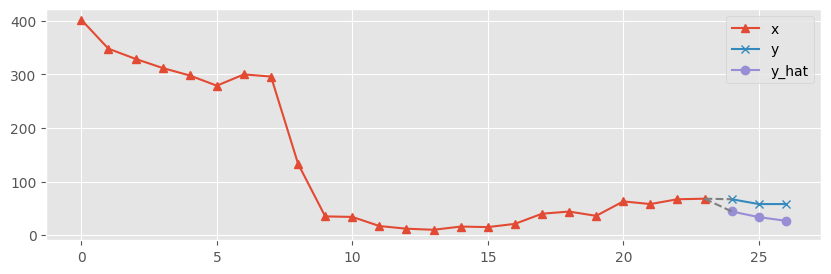

In [64]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(x_coords, x_to_plot, marker='^', label='x')
ax.plot(y_coords, y_to_plot, marker='x', label='y')
ax.plot(y_coords, y_hat_to_plot, marker='o', label='y_hat')
ax.plot([x_coords[-1],y_coords[0]], [x_to_plot[-1], y_to_plot[0].item()], '--', color='grey')
ax.plot([x_coords[-1],y_coords[0]], [x_to_plot[-1], y_hat_to_plot[0].item()], '--', color='grey')
ax.legend()